# Urban Testbed Project

In [1]:
# importing required libraries
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
import folium
import geopy.distance
from IPython.display import IFrame
ox.config(log_console=True, use_cache=True)

**Create Graph of Champaign**

In [2]:
place = 'Champaign, Illinois, USA'
gdf = ox.gdf_from_place(place)
area = ox.projection.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type='drive_service',simplify = True)

**Visualize Champaign Graph**

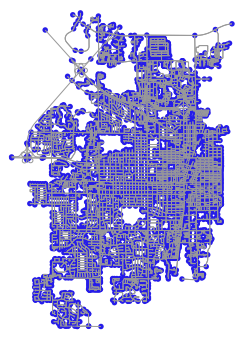

In [3]:
# Plot all nodes and edges
fig, ax = ox.plot_graph(G, node_size=30, node_color='#261CE9')   

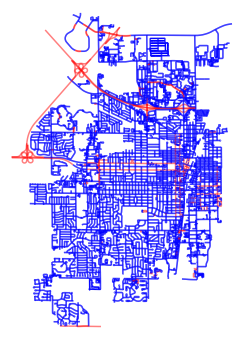

In [4]:
# Plot oneway streets
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

**Import and Visualize Population Data of Nearby Tracts**

Import data of the population and coordinates of the centers of nearby tracts.

In [5]:
file_name = 'Population.xlsx'
df = pd.read_excel(file_name)

## Convert dataframe into points for plotting
datapoints_list = list(df.to_records(index=False))

## Create folium map and add points

# Define and create map with appropriate boundaries
global_lat = []; global_lon = []; max_pop = 0
for point in datapoints_list:
    global_lat.append(point[2]) #lat
    global_lon.append(point[3]) #lon
    if point[2] > max_pop:
        max_pop = point[2]
min_point = [min(global_lat), min(global_lon)]
max_point =[max(global_lat), max(global_lon)]
m = folium.Map(zoom_start=1, tiles='cartodbdark_matter')
m.fit_bounds([min_point, max_point])

# Add source population data and corresponding points to the graph
for point in datapoints_list:
    folium.Circle(
          location=[point[2], point[3]],
          popup= "Population:"+str(point[1]),
          radius= 2*point[1]/max_pop,
          color='blue',
          fill=True,
          fill_color='blue'
    ).add_to(m)


# Add nodes (intersections) from our graph to the map
nodes_data = list(G.nodes(data=True))

for node in nodes_data:
    folium.CircleMarker(location=[node[1]['y'], node[1]['x']],
    radius= 0.5,
    color='red',
    fill=True).add_to(m)    
m

**Assign Population Scores to Node Based on Tract Data**

We assign what we call population score to every node in the graph. The population score is a measure of population density in the vicinity of the node. The score is generated by considering by taking the sum of (population of tract)/(distance to tract center) for each of the nearby tracts.

In [6]:
Population_Score = {}   

#create a new dict for population score
node_id = list(G.nodes())
for i in node_id:
    x1 = G.nodes[i]['x']
    y1 = G.nodes[i]['y']
    p1 = [y1,x1]
    pop_score = 0
    for j in range(43):
        x2 = df.at[j,'Long']
        y2 = df.at[j,'Lat']
        p2 = [y2,x2]
        pop = df.at[j,'Population']
        dis = geopy.distance.distance(p1, p2).km*1000+1
        pop_score = pop_score+pop/dis # sum of score components from each tract
    
    Population_Score.update({i:pop_score})
    
# Normalize population scores
Pop_max = max(Population_Score.values())
for i in node_id:
    pop = Population_Score.pop(i)
    pop = pop/Pop_max
    Population_Score.update({i:pop})
    
# Add population scores as attribute 'pop_score' to the nodes in the graph
for key, value in Population_Score.items():
    G.nodes[key]['pop_score'] = value
    
# Verify if the attribute is indeed added to the node
nodes_data = list(G.nodes(data=True))
print(nodes_data[0])

(5912707072, {'y': 40.0852037, 'x': -88.2362914, 'osmid': 5912707072, 'pop_score': 0.11762134436197234})


**Process Block Population Data to Desired Structure and Assign Scores to Nodes**

Find source for block population data of the following form: population of each block and coordinates of center or shape file of each block. We could only want to use the data of blocks in Champaign-Savoy-Urbana area. Then we create a list of datapoints of the form: (block center coordinates, block population)and use the above discussed population score method.

# Test OSMnx heatmap

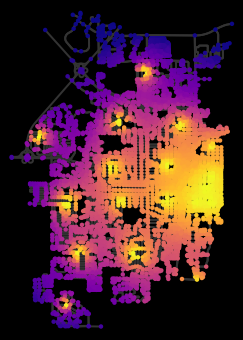

In [8]:
nc = ox.plot.get_node_colors_by_attr(G, 'pop_score', cmap='plasma')
fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, node_zorder=2,
                        edge_linewidth=2, edge_color='#333333', bgcolor='k')